In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyomo
from edisgo.edisgo import import_edisgo_from_files
import pyomo.environ as pm
from pyomo.opt import SolverStatus, TerminationCondition
import numpy as np
import pandas as pd

c:\users\anya.heider\appdata\local\continuum\miniconda3\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning: Ignoring declarative-like tuple value of attribute 'segment': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?
  "accidentally placed at the end of the line?" % k
c:\users\anya.heider\appdata\local\continuum\miniconda3\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning: Ignoring declarative-like tuple value of attribute 'cable': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?
  "accidentally placed at the end of the line?" % k


In [3]:
from edisgo.flex_opt.charging_ev import get_ev_data
from pathlib import Path
import edisgo.flex_opt.charging_ev as cEV

In [4]:
data_dir = Path( # TODO: set dir
    r"\\192.168.10.221\Daten_flexibel_02\simbev_results\Electrification_2050_simbev_run\cp_standing_times_mapping",
    # r"/home/local/RL-INSTITUT/kilian.helfenbein/RLI_simulation_results/simbev_results",
)
edisgo_dir = r'\\192.168.10.221\Daten_flexibel_02\simbev_results\eDisGo_object_files_full\Electrification_2050\1056\reduced'

In [5]:
edisgo_obj = import_edisgo_from_files(edisgo_dir, import_timeseries=True)

In [8]:
home_chargers = edisgo_obj.topology.charging_points_df.loc[edisgo_obj.topology.charging_points_df.use_case == 'home']
home_chargers.index

Index(['ChargingPoint_LVGrid_109035_2', 'ChargingPoint_LVGrid_109035_3',
       'ChargingPoint_LVGrid_109035_4', 'ChargingPoint_LVGrid_109035_5',
       'ChargingPoint_LVGrid_109035_6', 'ChargingPoint_LVGrid_109035_7',
       'ChargingPoint_LVGrid_109035_8', 'ChargingPoint_LVGrid_109035_9',
       'ChargingPoint_LVGrid_109035_10', 'ChargingPoint_LVGrid_109035_11',
       ...
       'ChargingPoint_LVGrid_102177_53', 'ChargingPoint_LVGrid_440493_42',
       'ChargingPoint_LVGrid_102579_54', 'ChargingPoint_LVGrid_102577_35',
       'ChargingPoint_LVGrid_440892_11', 'ChargingPoint_LVGrid_102773_12',
       'ChargingPoint_LVGrid_102178_32', 'ChargingPoint_LVGrid_97976_36',
       'ChargingPoint_LVGrid_102578_36', 'ChargingPoint_LVGrid_102178_33'],
      dtype='object', name='name', length=2635)

In [5]:
edisgo_obj.topology.charging_points_df.head()

,bus,geom,mvlv_subst_id,p_nom,use_case,voltage_level
name,,,,,,
ChargingPoint_LVGrid_402278_0,Bus_ChargingPoint_0,POINT (8.64110829879715 48.1502111922073),402278.0,0.150,fast,6
ChargingPoint_MVGrid_176_0,Bus_ChargingPoint_1,POINT (8.63950009879737 48.1533436922082),NaN,0.350,fast,5
ChargingPoint_MVGrid_176_1,Bus_ChargingPoint_2,POINT (8.59359959880376 48.1981386922197),NaN,0.350,fast,5
ChargingPoint_MVGrid_176_2,Bus_ChargingPoint_3,POINT (8.57592039880622 48.1715151922129),NaN,0.350,fast,5
ChargingPoint_LVGrid_27558_0,Bus_ChargingPoint_4,POINT (8.64626279879643 48.206548494882),27558.0,0.138,public,6


In [16]:
edisgo_obj.timeseries.charging_points_active_power.head()

,ChargingPoint_LVGrid_402278_0,ChargingPoint_MVGrid_176_0,ChargingPoint_MVGrid_176_1,ChargingPoint_MVGrid_176_2,ChargingPoint_LVGrid_27558_0,ChargingPoint_LVGrid_27558_1,ChargingPoint_LVGrid_27561_0,ChargingPoint_LVGrid_27561_1,ChargingPoint_LVGrid_27558_2,ChargingPoint_LVGrid_27558_3,...,ChargingPoint_LVGrid_25947_56,ChargingPoint_LVGrid_25947_57,ChargingPoint_LVGrid_400333_158,ChargingPoint_LVGrid_25947_58,ChargingPoint_LVGrid_400333_159,ChargingPoint_LVGrid_400333_160,ChargingPoint_LVGrid_25947_59,ChargingPoint_LVGrid_400333_161,ChargingPoint_LVGrid_400333_162,ChargingPoint_LVGrid_400333_163
2011-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
gdf_cps_total, df_standing_total = cEV.charging_existing_edisgo_object(data_dir, edisgo_dir, [])

Grid Nr. 176 with index 0 is being processed.
Grid Nr. 176 in scenario Electrification_2050_simbev_run is being processed.
It took 62.6 seconds to read in the data for grid 176 for scenario Electrification_2050_simbev_run.


In [39]:
df_standing_total.head()

,netto_charging_capacity,chargingdemand,charge_start,charge_end,cp_idx,cp_sub_idx,use_case,ags
0,9.9,17.325,29,55,0,1,2,8325011
1,9.9,12.375,65,106,0,1,2,8325011
2,9.9,4.950,115,132,0,1,2,8325011
3,9.9,24.750,138,152,0,1,2,8325011
4,9.9,4.950,157,158,0,1,2,8325011


In [ ]:
# Todo: optimise weekly
timeindex = edisgo_obj.timeseries.timeindex
timesteps_per_week = (7*24*4)
nr_iterations = (len(timeindex)/timesteps_per_week)
for week in range(nr_iterations):
    time_range = timeindex[timesteps_per_week*week:timesteps_per_week*(week+1)]

In [42]:
charging_tmp = pd.read_hdf(r'\\192.168.10.221\Daten_flexibel_02\simbev_results\Electrification_2050_simbev_run\eDisGo_charging_time_series\176\residual_charging_timeseries_home.h5')

In [43]:
charging_tmp.head()

8325011                                               ... 8325069            \
     0    1    2    3    4    5    6    7    8    9     ...    1223 1224 1226   
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   

                                      
  1227 1228 1230 1231 1232 1233 1234  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 5042 columns]

In [44]:
df_standing_times_home = df_standing_total.loc[df_standing_total.use_case == 3]

In [45]:
df_standing_times_work = df_standing_total.loc[df_standing_total.use_case == 4]

In [46]:
df_standing_times_home.head()

,netto_charging_capacity,chargingdemand,charge_start,charge_end,cp_idx,cp_sub_idx,use_case,ags
116988,9.9,7.425,92,98,0,1,3,8325011
116989,9.9,12.375,243,262,0,1,3,8325011
116990,9.9,7.425,436,510,0,1,3,8325011
116991,9.9,7.425,635,646,0,1,3,8325011
116992,9.9,7.425,764,770,0,1,3,8325011


In [50]:
def get_ev_data(ev_data, name):
    """
    Method to extract flexibility energy bands for ev charging processes. It
    can be chosen for which charging events the flexibility should be determined.
    Therefore it is necessary to specify the location one wants to look at.

    :param data_dir:
    :return:
    """
    ev_tech_data = pd.DataFrame(columns=[
        'charging_power', 'charging_efficiency', 'battery_capacity'],
                                index=[name])
    ev_tech_data.loc[name, 'charging_efficiency'] = 0.9
    ev_tech_data.loc[name, 'battery_capacity'] = ev_data['bat_cap'][0]
    ev_tech_data.loc[name, 'charging_power'] = \
        ev_data['netto_charging_capacity'][0]/\
        ev_tech_data.loc[name, 'charging_efficiency']

    ev_data['charging_time_full_load'] = \
        ev_data['chargingdemand'] / ev_data[
            'netto_charging_capacity'] * 4

    energy_band = get_ev_flexibility_bands(ev_data)
    return ev_tech_data, energy_band

In [48]:
def get_ev_flexibility_bands(charging_events):
    energy_level = 0
    time_step = 0
    energy_band = pd.DataFrame(index=[i for i in range(24 * 7 * 4 + 1)],
                               columns=['lower', 'upper'])
    for _, charging_event in charging_events.iterrows():
        energy_band.loc[time_step:charging_event['charge_start'] - 1, :] = \
            energy_level
        charging_time = int(np.ceil(charging_event['charging_time_full_load']))
        charging_fraction = charging_event['charging_time_full_load'] % 1
        # lower band
        energy_band.loc[charging_event['charge_start']:
                        charging_event['charge_end'] - charging_time,
        'lower'] = \
            energy_level
        energy_level_tmp = [
            energy_level + (i + charging_fraction) * charging_event[
                'netto_charging_capacity'] / 4
            for i in range(charging_time)]

        energy_band.loc[
        charging_event['charge_end'] - charging_time + 1:charging_event[
            'charge_end'], 'lower'] = energy_level_tmp
        # upper band
        energy_band.loc[charging_event['charge_start']:
                        charging_event['charge_start'] + charging_time - 2,
        'upper'] \
            = [energy_level + (i + 1) * charging_event[
            'netto_charging_capacity'] / 4
               for i in range(charging_time - 1)]

        energy_level += charging_event['chargingdemand']
        energy_band.loc[charging_event['charge_start'] + charging_time - 1:
                        charging_event['charge_end'], 'upper'] = energy_level
        # move to next event
        time_step = charging_event['charge_end'] + 1
    return energy_band

In [54]:
ev_data = df_standing_times_home.iloc[0:24]
ev_data.head()

,netto_charging_capacity,chargingdemand,charge_start,charge_end,cp_idx,cp_sub_idx,use_case,ags
116988,9.9,7.425,92,98,0,1,3,8325011
116989,9.9,12.375,243,262,0,1,3,8325011
116990,9.9,7.425,436,510,0,1,3,8325011
116991,9.9,7.425,635,646,0,1,3,8325011
116992,9.9,7.425,764,770,0,1,3,8325011


In [79]:
name = 'test'
ev_data = df_standing_times_home
ev_tech_data = pd.DataFrame(columns=[
    'charging_power', 'charging_efficiency'],
                            index=[name])
ev_tech_data.loc[name, 'charging_efficiency'] = 0.9 # Todo: replace with config data
ev_tech_data.loc[name, 'charging_power'] = \
    ev_data['netto_charging_capacity'].iloc[0]/\
    ev_tech_data.loc[name, 'charging_efficiency']

ev_data['charging_time_full_load'] = \
    ev_data['chargingdemand'] / ev_data[
        'netto_charging_capacity'] * 4

#energy_band = get_ev_flexibility_bands(ev_data)
ev_tech_data

c:\users\anya.heider\appdata\local\continuum\miniconda3\envs\edisgo_env\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,charging_power,charging_efficiency
test,11,0.9


In [80]:
cp_1 = ev_data.loc[ev_data.cp_idx == 0].loc[ev_data.cp_sub_idx == 1]
cp_1.head()

,netto_charging_capacity,chargingdemand,charge_start,charge_end,cp_idx,cp_sub_idx,use_case,ags,charging_time_full_load
116988,9.9,7.425,92,98,0,1,3,8325011,3.0
116989,9.9,12.375,243,262,0,1,3,8325011,5.0
116990,9.9,7.425,436,510,0,1,3,8325011,3.0
116991,9.9,7.425,635,646,0,1,3,8325011,3.0
116992,9.9,7.425,764,770,0,1,3,8325011,3.0


<AxesSubplot:>

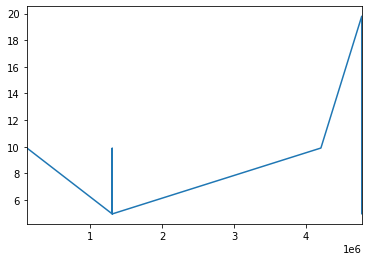

In [70]:
cp_2 = df_standing_times_home.loc[df_standing_times_home.cp_idx == 0].loc[df_standing_times_home.cp_sub_idx == 2]
cp_2.chargingdemand.plot()

In [74]:
df_standing_times_home.charge_end.max()

35616

In [76]:
35616/(24*4*7)

53.0

In [86]:
charging_events=cp_1
charging_events.head()

,netto_charging_capacity,chargingdemand,charge_start,charge_end,cp_idx,cp_sub_idx,use_case,ags,charging_time_full_load
116988,9.9,7.425,92,98,0,1,3,8325011,3.0
116989,9.9,12.375,243,262,0,1,3,8325011,5.0
116990,9.9,7.425,436,510,0,1,3,8325011,3.0
116991,9.9,7.425,635,646,0,1,3,8325011,3.0
116992,9.9,7.425,764,770,0,1,3,8325011,3.0


In [82]:
energy_level = 0
time_step = 0
time_horizon = 53 * 24 * 7 * 4
energy_band = pd.DataFrame(index=[i for i in range(time_horizon + 1)],
                           columns=['lower', 'upper'])
for _, charging_event in charging_events.iterrows():
    energy_band.loc[time_step:charging_event['charge_start'] - 1, :] = \
        energy_level
    charging_time = int(np.ceil(charging_event['charging_time_full_load']))
    charging_fraction = charging_event['charging_time_full_load'] % 1
    # lower band
    energy_band.loc[charging_event['charge_start']:
                    charging_event['charge_end'] - charging_time,
    'lower'] = \
        energy_level
    energy_level_tmp = [
        energy_level + (i + charging_fraction) * charging_event[
            'netto_charging_capacity'] / 4
        for i in range(charging_time)]

    energy_band.loc[
    charging_event['charge_end'] - charging_time + 1:charging_event[
        'charge_end'], 'lower'] = energy_level_tmp
    # upper band
    energy_band.loc[charging_event['charge_start']:
                    charging_event['charge_start'] + charging_time - 2,
    'upper'] \
        = [energy_level + (i + 1) * charging_event[
        'netto_charging_capacity'] / 4
           for i in range(charging_time - 1)]

    energy_level += charging_event['chargingdemand']
    energy_band.loc[charging_event['charge_start'] + charging_time - 1:
                    charging_event['charge_end'], 'upper'] = energy_level
    # move to next event
    time_step = charging_event['charge_end'] + 1

<AxesSubplot:>

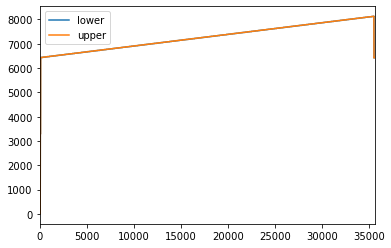

In [93]:
energy_band.plot()

In [ ]:
energy_band.loc[92:98]

In [ ]:
#energy_band.T.plot()

In [ ]:
time_index_tmp = pd.date_range('2018-01-01', periods=time_horizon, freq='15min')

In [6]:
flexibility_bands = pd.read_csv('grid_data/ev_flexibility_bands.csv', index_col=0)
flexibility_bands.head()

,upper_0,lower_0,power_0,upper_1,lower_1,power_1,upper_2,lower_2,power_2,upper_3,...,power_1209,upper_1215,lower_1215,power_1215,upper_1220,lower_1220,power_1220,upper_1226,lower_1226,power_1226
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
timeindex = pd.date_range('2029-01-01', '2029-01-08', freq='15min')
len(timeindex)

673

In [81]:
len(flexibility_bands)

674

In [88]:
bands = flexibility_bands.iloc[0:673].set_index(timeindex)

In [89]:
columns_upper = [col for col in bands.columns if 'upper' in col]
columns_lower = [col for col in bands.columns if 'lower' in col]
columns_power = [col for col in bands.columns if 'power' in col]

In [90]:
aggregated_bands = pd.DataFrame()
aggregated_bands['upper'] = bands[columns_upper].sum(axis=1)
aggregated_bands['lower'] = bands[columns_lower].sum(axis=1)
aggregated_bands['power'] = bands[columns_power].sum(axis=1)
aggregated_bands.head()

,upper,lower,power
2029-01-01 00:00:00,4589.0325,3875.6475,1309.5
2029-01-01 00:15:00,4627.8675,3921.0750,1309.5
2029-01-01 00:30:00,4648.5450,3964.8600,1287.5
2029-01-01 00:45:00,4667.5575,4016.0700,1221.5
2029-01-01 01:00:00,4679.1225,4055.7375,1133.5


<AxesSubplot:>

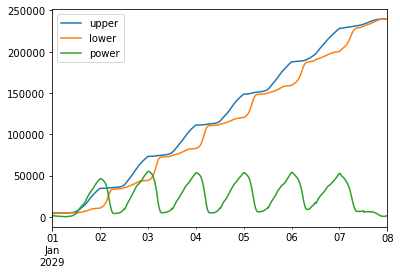

In [91]:
aggregated_bands.plot()

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [74]:
# 2D heatmap with monthly-hourly resolution
def plot_hm_quarterly(df_power, df_energy, v_max=None, filename=None, title=None):

    
    fig, ax =  plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(bottom=0.3)
    v_min = 0

    df = pd.DataFrame(df_power)

    df['quarter_of_day'] = df.index.hour * 4 + np.floor(df.index.minute/15)
    grouped = df.groupby([df.index.day, 'quarter_of_day']).sum().unstack()
    grouped.columns = ["{}:{}".format(int(d/4), (d%4)*15) for d in grouped.columns.get_level_values(1)]
    grouped.index = [calendar.day_name[m-1] for m in grouped.index]

    g = sns.heatmap(grouped, cmap='RdYlGn_r', xticklabels=False, vmin=v_min, ax=ax[0],
                    cbar=True)  
    g.set_xticks(np.arange(0, 97, 24))
    g.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '00:00'])

    ax[0].title.set_text('Shiftable Power [MW]')

    df = pd.DataFrame(df_energy)

    df['quarter_of_day'] = df.index.hour * 4 + np.floor(df.index.minute/15)
    grouped = df.groupby([df.index.day, 'quarter_of_day']).sum().unstack()
    grouped.columns = ["{}:{}".format(int(d/4), (d%4)*15) for d in grouped.columns.get_level_values(1)]
    grouped.index = [calendar.day_name[m-1] for m in grouped.index]

    g = sns.heatmap(grouped, cmap='RdYlGn_r', xticklabels=False, vmin=v_min, ax=ax[1],
                    cbar=True)  
    g.set_xticks(np.arange(0, 97, 24))
    g.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '00:00'])
    g.set_yticks([])

    ax[1].title.set_text('Shiftable Energy [MWh]')
    if title:
        fig.suptitle(title)
        
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

In [77]:
use_case = 'homecharging'
use_case.capitalize()

'Homecharging'

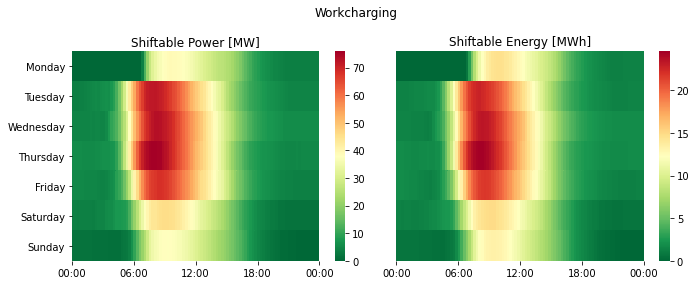

In [86]:
df_power = aggregated_bands['power'].iloc[:-1]/1e3
df_energy = (aggregated_bands['upper'].iloc[:-1] - aggregated_bands['lower'].iloc[:-1])/1e3
use_case = 'workcharging'
filename = 'plots/{}.pdf'.format(use_case)
plot_hm_quarterly(df_power, df_energy, title=use_case.capitalize(), filename=filename)

In [64]:
grouped

,0:0.0,0:15.0,0:30.0,0:45.0,1:0.0,1:15.0,1:30.0,1:45.0,2:0.0,2:15.0,...,21:30.0,21:45.0,22:0.0,22:15.0,22:30.0,22:45.0,23:0.0,23:15.0,23:30.0,23:45.0
1,713.3850,706.7925,683.6850,651.4875,623.3850,591.1650,547.4025,517.6800,487.1250,449.9775,...,19404.9225,19972.6875,20538.7875,21113.6625,21648.8925,22160.2050,22606.6050,23007.6225,23324.4900,23566.2750
2,23742.0450,23449.9275,23148.7425,22808.7900,22429.2375,21972.0825,21470.3325,20945.4750,20304.2700,19543.3875,...,24234.5250,24750.3150,25294.9725,25873.4025,26426.2500,26969.1750,27475.8075,27946.1025,28386.6750,28776.0825
3,29052.4275,28793.2500,28473.0075,28163.4525,27819.2475,27391.6575,26911.2600,26286.4575,25501.5900,24523.6275,...,23486.9175,24052.9725,24600.0600,25124.0625,25672.0050,26158.8825,26658.1125,27131.7825,27564.2100,27992.4975
4,28376.2125,28160.8200,27892.5975,27599.6250,27300.0150,26952.5475,26496.1575,25968.8025,25302.0150,24447.1050,...,23862.3300,24370.6050,24892.0650,25361.5725,25797.2400,26225.4825,26705.6775,27173.4975,27624.8250,27973.8450
5,28243.6650,27946.5075,27647.7075,27247.4325,26747.3025,26257.0500,25718.0850,25109.7975,24404.9400,23624.1450,...,23088.0600,23711.0850,24330.8025,24920.0100,25532.2800,26107.4025,26675.9100,27182.4975,27669.2625,28100.7225
6,28400.1750,28022.1975,27617.8275,27291.8700,26949.4200,26601.9975,26244.6525,25814.7000,25378.9650,24959.7225,...,23568.7725,24063.8625,24563.8800,25020.9900,25473.1500,25982.2125,26530.0425,26980.5150,27429.3225,27728.7975
7,27873.9900,27351.6300,26839.1700,26309.4075,25883.6175,25510.6125,25134.3000,24795.1125,24376.7025,23963.2425,...,88.2900,62.7075,42.0750,32.1750,17.3250,2.4750,0.0000,0.0000,0.0000,0.0000
8,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


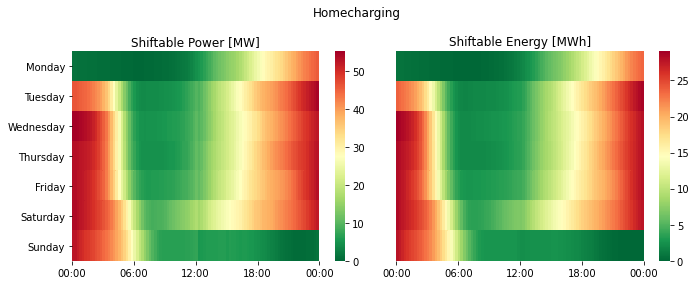

In [73]:
df_dumb = aggregated_bands['power'].iloc[:-1]/1e3
df_smart = (aggregated_bands['upper'].iloc[:-1] - aggregated_bands['lower'].iloc[:-1])/1e3
filename = 'plots/homecharging.pdf'


fig, ax =  plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(bottom=0.3)
v_min = 0

df = pd.DataFrame(df_dumb)

df['quarter_of_day'] = df.index.hour * 4 + np.floor(df.index.minute/15)
grouped = df.groupby([df.index.day, 'quarter_of_day']).sum().unstack()
grouped.columns = ["{}:{}".format(int(d/4), (d%4)*15) for d in grouped.columns.get_level_values(1)]
grouped.index = [calendar.day_name[m-1] for m in grouped.index]

g = sns.heatmap(grouped, cmap='RdYlGn_r', xticklabels=False, vmin=v_min, ax=ax[0],
                cbar=True)  
g.set_xticks(np.arange(0, 97, 24))
g.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '00:00'])

ax[0].title.set_text('Shiftable Power [MW]')

df = pd.DataFrame(df_smart)

df['quarter_of_day'] = df.index.hour * 4 + np.floor(df.index.minute/15)
grouped = df.groupby([df.index.day, 'quarter_of_day']).sum().unstack()
grouped.columns = ["{}:{}".format(int(d/4), (d%4)*15) for d in grouped.columns.get_level_values(1)]
grouped.index = [calendar.day_name[m-1] for m in grouped.index]

g = sns.heatmap(grouped, cmap='RdYlGn_r', xticklabels=False, vmin=v_min, ax=ax[1],
                cbar=True)  
g.set_xticks(np.arange(0, 97, 24))
g.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '00:00'])
g.set_yticks([])

ax[1].title.set_text('Shiftable Energy [MWh]')
fig.suptitle('Homecharging')
plt.tight_layout()
plt.savefig(filename)
plt.show()


In [60]:
np.arange(0, 97, 24)

array([ 0, 24, 48, 72, 96])

In [37]:
calendar.day_name[1]

'Tuesday'

In [55]:
96/4

24.0